In [1]:
# Install correct dependencies
# Developed w/ Python 3.9.6

# %pip cache purge
# %pip install librosa==0.10.1
# %pip install llvmlite==0.43.0
# %pip install pandas==1.5.3
# %pip install protobuf==3.20.3
# %pip install click==8.1.3
# %pip install tensorflow-macos tensorflow-metal

from random_forest_utils import random_forest
from logistic_regression_utils import logistic_regression

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from keras import utils

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.preprocessing import StandardScaler

In [2]:
# Use Librose to perform Feature Extraction

DATA_DIR = "/Users/dmwelch/Development/NYU/MIR/finalProj/Data/genres_original"

def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=30)
    features = np.array([])

    # MFCC
    
    s = librosa.feature.mfcc(y=y, sr=sr)
    mfccs_mean = mfccs.mean(axis=1)
    features = np.hstack((features, mfccs_mean))

    # Chromagram
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = chroma.mean(axis=1)
    features = np.hstack((features, chroma_mean))

    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = contrast.mean(axis=1)
    features = np.hstack((features, contrast_mean))

    # Tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_mean = tonnetz.mean(axis=1)
    features = np.hstack((features, tonnetz_mean))

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    zcr_mean = zcr.mean()
    features = np.hstack((features, zcr_mean))

    # Spectral Roll-off
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = rolloff.mean()
    features = np.hstack((features, rolloff_mean))

    return features

genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# dataset = []

# for genre in genres:
#     genre_dir = os.path.join(DATA_DIR, genre)
#     for filename in os.listdir(genre_dir):
#         if filename.endswith('.wav'):
#             file_path = os.path.join(genre_dir, filename)
#             features = extract_features(file_path)
#             dataset.append([features, genre])


# # Convert to DataFrame
# df = pd.DataFrame(dataset, columns=['features', 'label'])

import pickle

# # Save the DataFrame
# with open('dataset.pkl', 'wb') as f:
#     pickle.dump(df, f)

# Load the DataFrame
with open('dataset.pkl', 'rb') as f:
    df = pickle.load(f)

X = np.array(df['features'].tolist())
y = np.array(df['label'].tolist())

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Portion 20% of data for testing, the rest for training
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [3]:
# TRAINING THE ML MODELS, MAKING PREDICTIONS

# ADAboost
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)

# CATBoost
cat_clf = CatBoostClassifier(
    iterations=100,
    learning_rate=0.5,
    depth=6,
    loss_function='MultiClass',
    verbose=False,
    random_state=42
)
cat_clf.fit(X_train, y_train)
y_pred_cat = cat_clf.predict(X_test)

# Random Forest
rf = random_forest()
rf_model = rf.gen()
rf.fit(X_train, y_train)
rf_y_pred = rf.pred(X_test)

# Logistical Regression
lr = logistic_regression()
lr_model = lr.gen()
lr.fit(X_train, y_train)
lr_y_pred = lr.pred(X_test)

# K-Neighbors Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)
knn_y_pred = knn_clf.predict(X_test)

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(
    max_depth=10,               # Maximum depth of the tree
    min_samples_split=2,        # Minimum number of samples required to split an internal node
    random_state=42             # Ensures reproducibility
)
dt_clf.fit(X_train, y_train)
dt_y_pred = dt_clf.predict(X_test)



/Users/dmwelch/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


initializing random forest classifier
initializing logistic regression classifier


/Users/dmwelch/.pyenv/versions/3.9.6/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
# TRAIN THE TENSORFLOW MODEL

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data to add a channels dimension
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Convert integer labels to one-hot vectors
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

# Define the CNN architecture
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    
    Dense(len(le.classes_), activation='softmax')  # Number of genres as output units
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    optimizer='adam',                 # Adaptive optimizer
    metrics=['accuracy']              # Evaluation metric
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train_cnn, y_train_cnn,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions
y_pred_cnn = model.predict(X_test_cnn)
y_pred_cnn_classes = y_pred_cnn.argmax(axis=1)
y_test_classes = y_test_cnn.argmax(axis=1)

# Save the model
model.save('genre_cnn_model.h5')

# Load the model
loaded_cnn = load_model('genre_cnn_model.h5')

/Users/dmwelch/.pyenv/versions/3.9.6/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-04 00:35:04.602488: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-04 00:35:04.602521: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-04 00:35:04.602542: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-04 00:35:04.602565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-04 00:35:04.602586: I tensorflow/core/common_runtime/pluggable_device/pluggable_dev

Epoch 1/100


2024-12-04 00:35:05.254202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1301 - loss: 2.2399 - val_accuracy: 0.3938 - val_loss: 1.8483
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2956 - loss: 1.8890 - val_accuracy: 0.4313 - val_loss: 1.6057
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4344 - loss: 1.5866 - val_accuracy: 0.4313 - val_loss: 1.5610
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4883 - loss: 1.4926 - val_accuracy: 0.4625 - val_loss: 1.5163
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4790 - loss: 1.5305 - val_accuracy: 0.5250 - val_loss: 1.3755
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5436 - loss: 1.3882 - val_accuracy: 0.4938 - val_loss: 1.3766
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5555 - loss: 1.2961 - val_accuracy: 0.5437 - val_loss: 1.2704
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5690 - loss: 1.2112 - val_accuracy: 0.5375 - val_l

/var/folders/hn/n143pnwn29dfd740rsblrsx80000gn/T/ipykernel_44327/1207900378.py:90: FutureWarning: Passing 'suffixes' which cause duplicate columns {'support_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = reduce(lambda left, right: pd.merge(left, right, on='class'), dfs)
/var/folders/hn/n143pnwn29dfd740rsblrsx80000gn/T/ipykernel_44327/1207900378.py:90: FutureWarning: Passing 'suffixes' which cause duplicate columns {'support_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_df = reduce(lambda left, right: pd.merge(left, right, on='class'), dfs)


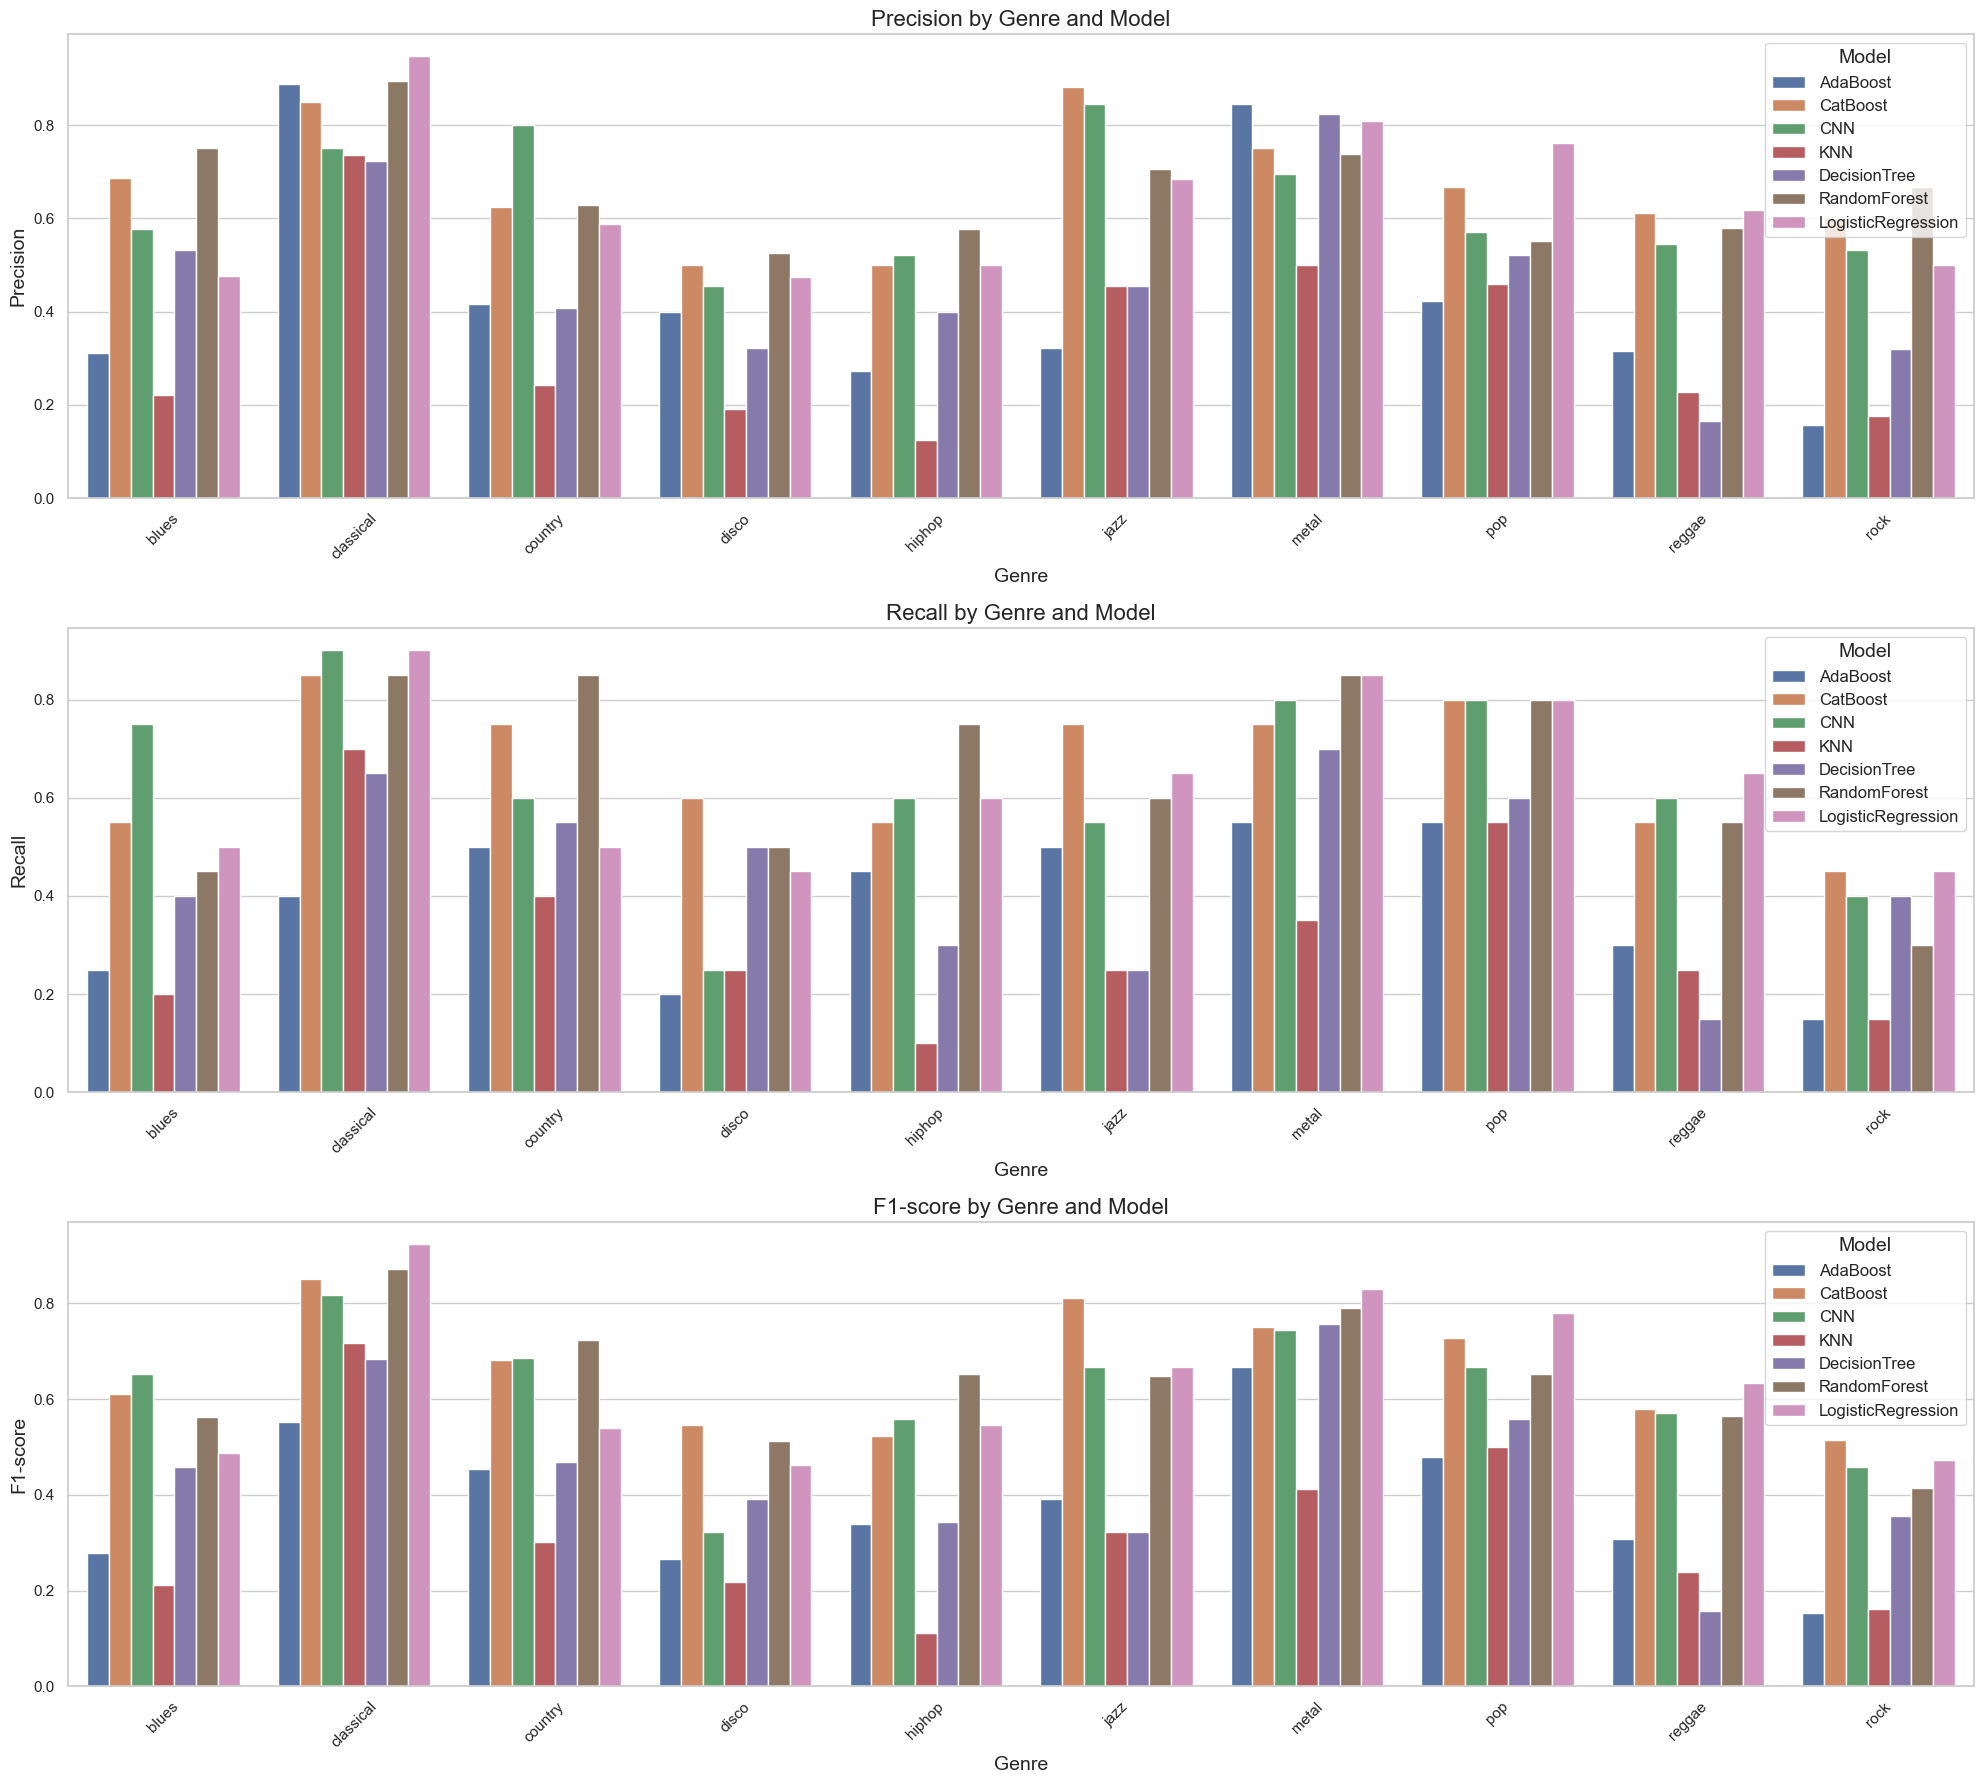

In [6]:
# GENERATING REPORTS
ada_report = classification_report(y_test, y_pred_ada, target_names=le.classes_, output_dict=True)
cat_report = classification_report(y_test, y_pred_cat, target_names=le.classes_, output_dict=True)
rf_report = classification_report(y_test, rf_y_pred, target_names=le.classes_, output_dict=True)
lr_report = classification_report(y_test, lr_y_pred, target_names=le.classes_, output_dict=True)
knn_report = classification_report(y_test, knn_y_pred, target_names=le.classes_, output_dict=True)
dt_report = classification_report(y_test, dt_y_pred, target_names=le.classes_, output_dict=True)
cnn_report = classification_report(y_test_classes, y_pred_cnn_classes, target_names=le.classes_, output_dict=True)

# Convert reports to DataFrames and transpose
ada_df = pd.DataFrame(ada_report).transpose()
cat_df = pd.DataFrame(cat_report).transpose()
rf_df = pd.DataFrame(rf_report).transpose()
knn_df = pd.DataFrame(knn_report).transpose()
dt_df = pd.DataFrame(dt_report).transpose()
cnn_df = pd.DataFrame(cnn_report).transpose()
lr_df = pd.DataFrame(lr_report).transpose()

# Reset index to have 'class' as a column
ada_df = ada_df.reset_index().rename(columns={'index': 'class'})
cat_df = cat_df.reset_index().rename(columns={'index': 'class'})
rf_df = rf_df.reset_index().rename(columns={'index': 'class'})
lr_df = lr_df.reset_index().rename(columns={'index': 'class'})
knn_df = knn_df.reset_index().rename(columns={'index': 'class'})
dt_df = dt_df.reset_index().rename(columns={'index': 'class'})
cnn_df = cnn_df.reset_index().rename(columns={'index': 'class'})

# Define the list of aggregate metrics to remove
aggregate_metrics = ['accuracy', 'macro avg', 'weighted avg']

# Function to remove aggregate metrics from a DataFrame
def remove_aggregate_metrics(df):
    return df[~df['class'].isin(aggregate_metrics)]

# Apply the function to each DataFrame
ada_df = remove_aggregate_metrics(ada_df)
cat_df = remove_aggregate_metrics(cat_df)
rf_df = remove_aggregate_metrics(rf_df)
lr_df = remove_aggregate_metrics(lr_df)
knn_df = remove_aggregate_metrics(knn_df)
dt_df = remove_aggregate_metrics(dt_df)
cnn_df = remove_aggregate_metrics(cnn_df)

# Rename columns to include model names
ada_df = ada_df.rename(columns={
    'precision': 'precision_AdaBoost',
    'recall': 'recall_AdaBoost',
    'f1-score': 'f1-score_AdaBoost'
})

cat_df = cat_df.rename(columns={
    'precision': 'precision_CatBoost',
    'recall': 'recall_CatBoost',
    'f1-score': 'f1-score_CatBoost'
})

cnn_df = cnn_df.rename(columns={
    'precision': 'precision_CNN',
    'recall': 'recall_CNN',
    'f1-score': 'f1-score_CNN'
})

rf_df = rf_df.rename(columns={
    'precision': 'precision_RandomForest',
    'recall': 'recall_RandomForest',
    'f1-score': 'f1-score_RandomForest'
})

lr_df = lr_df.rename(columns={
    'precision': 'precision_LogisticRegression',
    'recall': 'recall_LogisticRegression',
    'f1-score': 'f1-score_LogisticRegression'
})

knn_df = knn_df.rename(columns={
    'precision': 'precision_KNN',
    'recall': 'recall_KNN',
    'f1-score': 'f1-score_KNN'
})

dt_df = dt_df.rename(columns={
    'precision': 'precision_DecisionTree',
    'recall': 'recall_DecisionTree',
    'f1-score': 'f1-score_DecisionTree'
})

# Merge all DataFrames on 'class'
dfs = [ada_df, cat_df, cnn_df, knn_df, dt_df, rf_df, lr_df]
from functools import reduce
merged_df = reduce(lambda left, right: pd.merge(left, right, on='class'), dfs)

# Melt the DataFrame to long format
metrics = ['precision', 'recall', 'f1-score']
models = ['AdaBoost', 'CatBoost', 'CNN', 'KNN', 'DecisionTree', 'RandomForest', 'LogisticRegression']

# Create the list of value variables
value_vars = []
for metric in metrics:
    for model in models:
        value_vars.append(f'{metric}_{model}')

# Melt the DataFrame
melted_df = merged_df.melt(
    id_vars='class', 
    value_vars=value_vars,
    var_name='Metric_Model', 
    value_name='Score'
)

# Split 'Metric_Model' into 'Metric' and 'Model'
melted_df[['Metric', 'Model']] = melted_df['Metric_Model'].str.rsplit('_', n=1, expand=True)
melted_df = melted_df.drop('Metric_Model', axis=1)

# Set Seaborn style for aesthetics
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(20, 18))

# Define the list of metrics
metrics = ['precision', 'recall', 'f1-score']

for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, i)
    
    # Filter the DataFrame for the current metric
    data = melted_df[melted_df['Metric'] == metric]
    
    # Create a barplot
    sns.barplot(x='class', y='Score', hue='Model', data=data)
    
    # Set plot titles and labels
    plt.title(f'{metric.capitalize()} by Genre and Model', fontsize=16)
    plt.xlabel('Genre', fontsize=14)
    plt.ylabel(metric.capitalize(), fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust legend
    plt.legend(title='Model', fontsize=12, title_fontsize=14)
    
# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

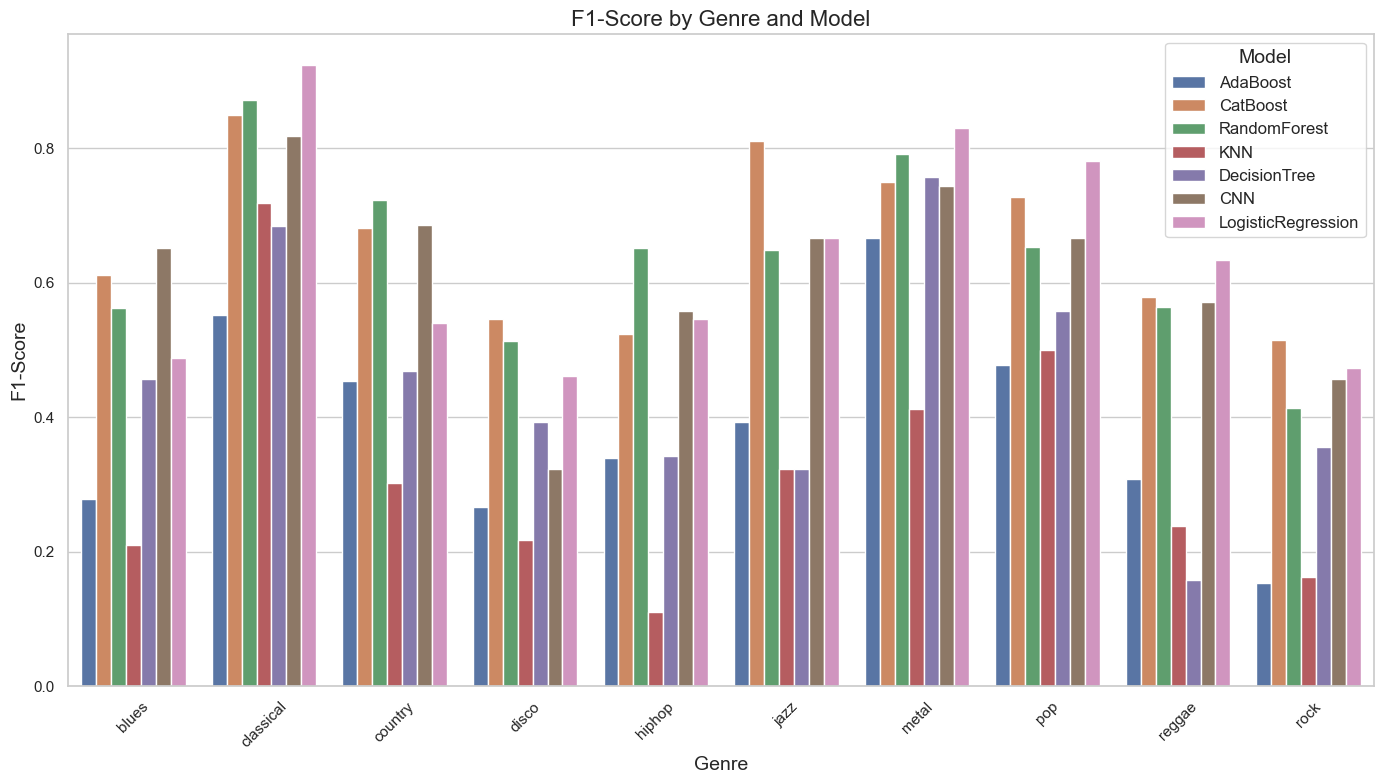

In [7]:
from sklearn.metrics import classification_report
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

# GENERATING REPORTS
ada_report = classification_report(y_test, y_pred_ada, target_names=le.classes_, output_dict=True)
cat_report = classification_report(y_test, y_pred_cat, target_names=le.classes_, output_dict=True)
rf_report = classification_report(y_test, rf_y_pred, target_names=le.classes_, output_dict=True)
lr_report = classification_report(y_test, lr_y_pred, target_names=le.classes_, output_dict=True)
knn_report = classification_report(y_test, knn_y_pred, target_names=le.classes_, output_dict=True)
dt_report = classification_report(y_test, dt_y_pred, target_names=le.classes_, output_dict=True)
cnn_report = classification_report(y_test_classes, y_pred_cnn_classes, target_names=le.classes_, output_dict=True)

# Convert reports to DataFrames and transpose
ada_df = pd.DataFrame(ada_report).transpose()
cat_df = pd.DataFrame(cat_report).transpose()
rf_df = pd.DataFrame(rf_report).transpose()
knn_df = pd.DataFrame(knn_report).transpose()
dt_df = pd.DataFrame(dt_report).transpose()
cnn_df = pd.DataFrame(cnn_report).transpose()
lr_df = pd.DataFrame(lr_report).transpose()

# Reset index to have 'class' as a column
dfs = [ada_df, cat_df, rf_df, knn_df, dt_df, cnn_df, lr_df]
for df in dfs:
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'class'}, inplace=True)

# Define the list of aggregate metrics to remove
aggregate_metrics = ['accuracy', 'macro avg', 'weighted avg']

# Function to remove aggregate metrics from a DataFrame
def remove_aggregate_metrics(df):
    return df[~df['class'].isin(aggregate_metrics)]

# Function to keep only 'class' and 'f1-score' columns
def keep_f1_score(df):
    return df[['class', 'f1-score']]

# Clean and prepare each DataFrame
model_names = ['AdaBoost', 'CatBoost', 'RandomForest', 'KNN', 'DecisionTree', 'CNN', 'LogisticRegression']
cleaned_dfs = []

for df, model_name in zip(dfs, model_names):
    df = remove_aggregate_metrics(df)
    df = keep_f1_score(df)
    df.rename(columns={'f1-score': f'F1_{model_name}'}, inplace=True)
    cleaned_dfs.append(df)

# Merge all DataFrames on 'class'
merged_df = reduce(lambda left, right: pd.merge(left, right, on='class'), cleaned_dfs)

# Melt the DataFrame to long format
value_vars = [f'F1_{model}' for model in model_names]

melted_df = merged_df.melt(
    id_vars='class', 
    value_vars=value_vars,
    var_name='Model', 
    value_name='F1_Score'
)

# Extract Model Names
melted_df['Model'] = melted_df['Model'].str.replace('F1_', '')

# Set Seaborn style for aesthetics
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(14, 8))

# Create a barplot
sns.barplot(x='class', y='F1_Score', hue='Model', data=melted_df)

# Set plot titles and labels
plt.title('F1-Score by Genre and Model', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust legend
plt.legend(title='Model', fontsize=12, title_fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

                Model  Average F1 Score
0            CatBoost          0.659351
1        RandomForest          0.639300
2  LogisticRegression          0.634267
3                 CNN          0.614288
4        DecisionTree          0.449538
5            AdaBoost          0.388896
6                 KNN          0.319347


/var/folders/hn/n143pnwn29dfd740rsblrsx80000gn/T/ipykernel_44327/729123584.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average F1 Score', y='Model', data=average_f1_df, palette='viridis')


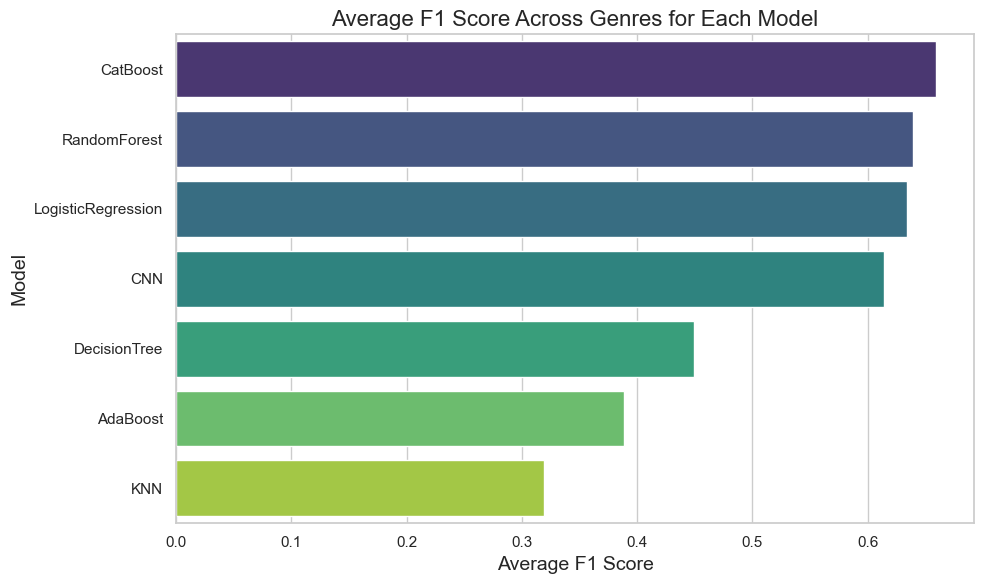

In [8]:
# Generate average F1 Score across genres for each model

# Step 1: Extract F1 score columns
f1_columns = [col for col in merged_df.columns if col.startswith('F1_')]

# Step 2: Compute the average F1 score for each model
average_f1_scores = {}
for col in f1_columns:
    mean_f1 = merged_df[col].mean()
    model_name = col.replace('F1_', '')
    average_f1_scores[model_name] = mean_f1

# Step 3: Create a DataFrame of the average F1 scores
average_f1_df = pd.DataFrame(list(average_f1_scores.items()), columns=['Model', 'Average F1 Score'])
average_f1_df = average_f1_df.sort_values(by='Average F1 Score', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(average_f1_df)

# Step 4: Plotting the average F1 scores
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Average F1 Score', y='Model', data=average_f1_df, palette='viridis')
plt.title('Average F1 Score Across Genres for Each Model', fontsize=16)
plt.xlabel('Average F1 Score', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.tight_layout()
plt.show()